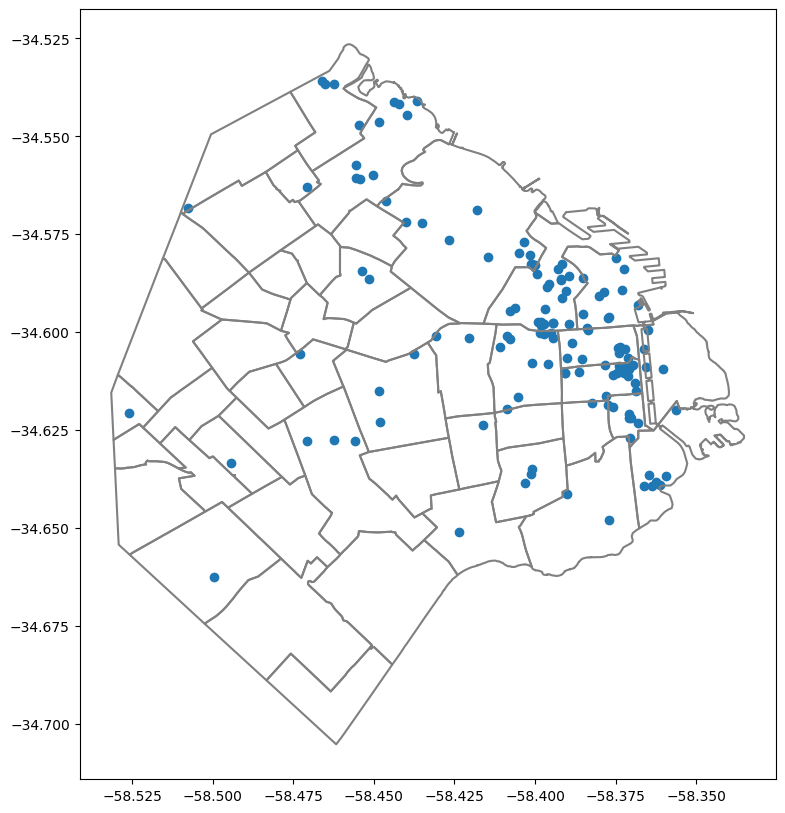

In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import seaborn.objects as so
import networkx as nx # Construcción de la red en NetworkX
import scipy
import template_funciones

# Preámbulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

#Pasamos el archivo visitantes.txt a dataFrame

visitantes1 = pd.read_csv('https://raw.githubusercontent.com/lrnyari/tp-alc/main/visitas.txt') #convierte el archivo visitantes.txt en un dataframe
visitantes2 = visitantes1.rename(columns={'3.866000000000000000e+03': 'w'}) #cambia el nombre de la columna 3.866000000000000000e+03 por w
nueva_fila = pd.DataFrame({'w': [3866]}) #creo otro dataframe, que tiene solo una columna y una fila, con la columna de nombre w y con el dato del numero 3866
w = pd.concat([nueva_fila, visitantes2], ignore_index=True) #le agrego a visitantes 2, arriba de todo, la fila de nueva_fila

## Visualización

<Axes: >

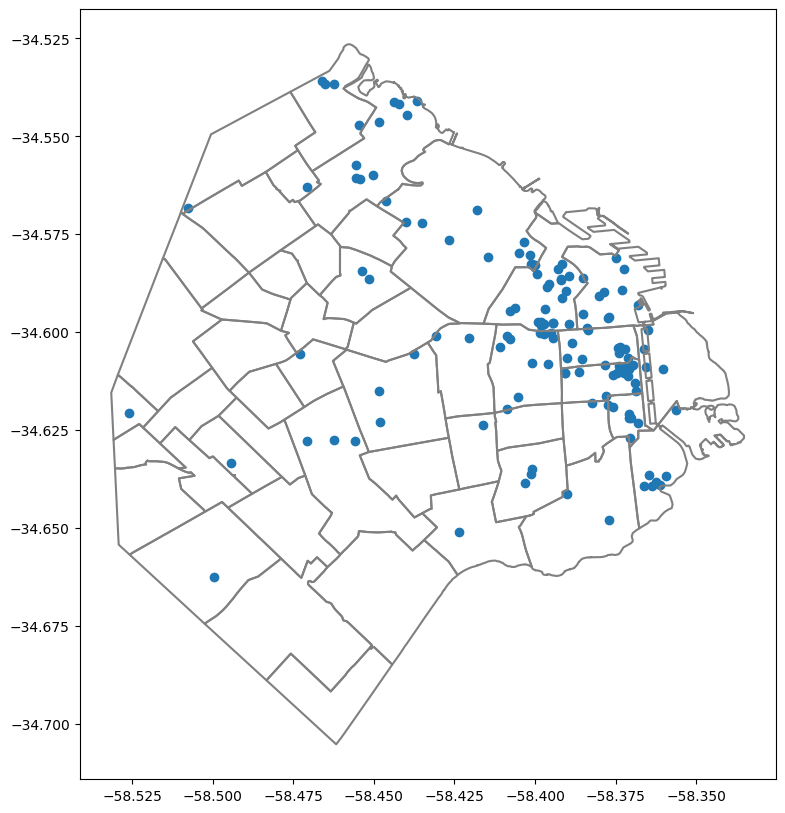

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
m = 3 # Cantidad de links por nodo
A = template_funciones.construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

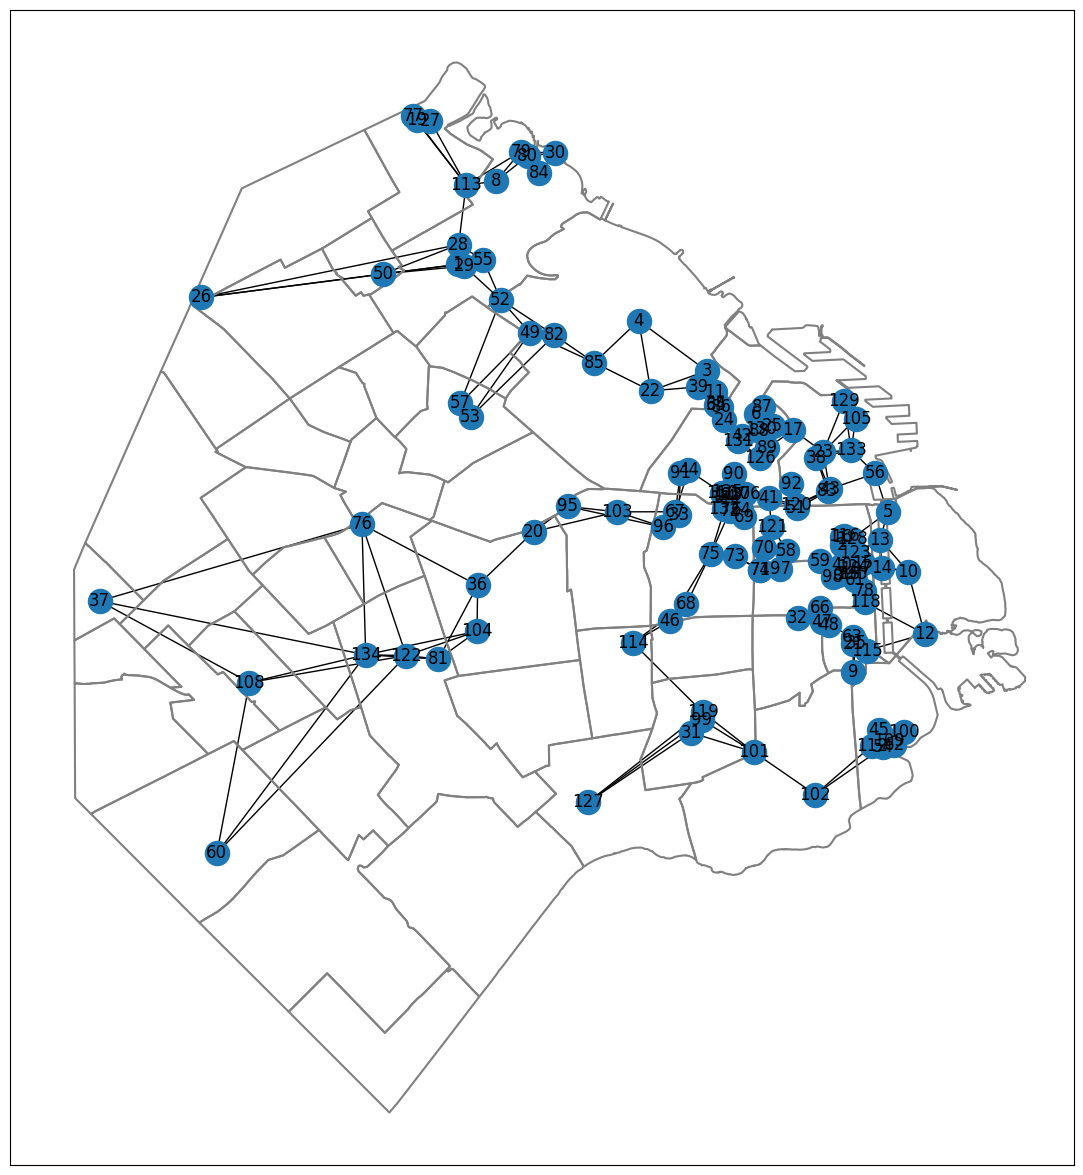

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

## Punto 1:

Dado $\mathbf{p}$, el vector de rankings de tamaño N que cumple la siguiente igualdad:

$$
\mathbf{p} = (1 - \alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}_N
$$

Queremos ver que el vector $\mathbf{p}$ es solución de la ecuación:

$$
M \mathbf{p} = \mathbf{b}, \quad \text{con} \quad M = \frac{N}{\alpha} \left(I - (1 - \alpha) C \right) \quad \text{y} \quad \mathbf{b} = \mathbf{1}_N.
$$

Partiendo de la ecuación:

$$
\mathbf{p} = (1 - \alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}_N
$$

Podemos reordenarla como:

$$
\mathbf{p} - (1 - \alpha) C \mathbf{p} = \frac{\alpha}{N} \mathbf{1}_N
$$

Luego, factorizando $\mathbf{p}$, obtenemos:

$$
\left( I - (1 - \alpha) C \right) \mathbf{p} = \frac{\alpha}{N} \mathbf{1}_N
$$

Multiplicando ambos lados por $\frac{N}{\alpha}$, obtenemos:

$$
\frac{N}{\alpha} \left( I - (1 - \alpha) C \right) \mathbf{p} = \mathbf{1}_N
$$

Por definición de **M** y cancelando términos del lado derecho de la igualdad, obtenemos:

$$
M \mathbf{p} = \mathbf{1}_N = \mathbf{b}
$$

$\square$

## Punto 2:


Para que la ecuación lineal:

$$
Mp = b
$$

tenga una única solución, la matriz **M** debe ser inversible, lo que equivale a decir que, el único vector x  que cumple

$$
Mx = 0
$$

es el vector nulo.

Queremos ver que la matriz M tal como fue construida
para los museos, cuando 0 < α < 1 cumple con la condición anterior.

Teniendo en cuenta que **C** es una matriz de transición estocástica por columnas (es decir que cada columna suma 1), para este rango de valores de α,  $\frac{N}{\alpha}$ es siempre positivo por lo que no influye en la inversibilidad de M.

Luego, basta con demostrar que $A = I - (1 - \alpha) C$ es inversible para concluir que M también lo es (siempre tomando como hipótesis 0 < α < 1).

Supongamos que existe un vector $ x \ne 0 $ tal que:

$$
Ax = (I - (1 - \alpha)C)x = 0
$$

Entonces:

$$x - (1 - \alpha) C x = 0 \iff
x = (1 - \alpha) Cx
$$

Ahora, si aplico norma 1 de ambos lados, como C es estocástica y se cumple  que $\|C\|_1 = 1$:

$$
\|x\|_1 = \left\|(1 - \alpha) Cx\right\|_1 \iff
\|x\|_1 = |(1 - \alpha)| \left\|x\right\|_1
$$

pero como $\|x\|_1$ es una constante, obtenemos que:

$$1 = |(1 - \alpha)|$$

*Absurdo*, ya que 0 < α < 1.

Entonces, la única solución a $ Ax = 0 $ es efectivamente:

$$
x = 0
$$

Luego, A es inversible cuando 0 < α < 1, y en consecuencia, M = $\frac{N}{\alpha}A $ también lo es.

$\square$

## Punto 3):

Calculamos el pagerank de cada museo para m=3 y alpha = 1/5 y vizualizamos en el mapa cada museo con un tamaño de nodo proporcional al mismo.

Mostramos los numeros de los 3 museos más centrales.




Museos más centrales: 
 117    0.024135
125    0.023529
18     0.021281
dtype: float64


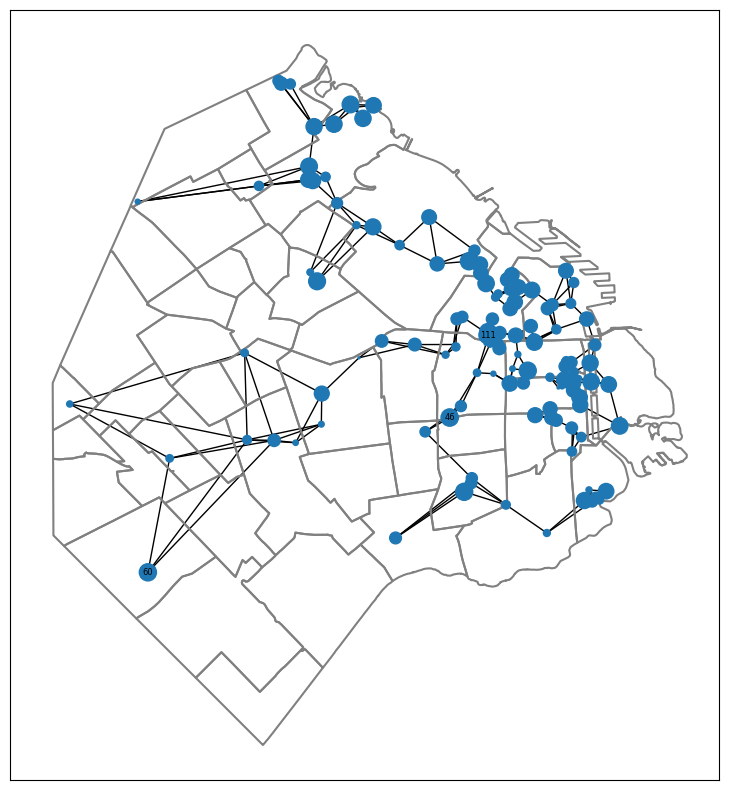

In [8]:
template_funciones.prcongrafico(D, 3, 1/5)


**Variación de m:**

Ahora vamos a ver como cambia el valor de pagerank para m = 1,3,5,10.

Para eso graficamos el valor de pagerank en funcion de m, de los museos que resulten los 3 mas centrales para algún valor de m.


In [38]:

dic = template_funciones.dicPagerankSobreM(D, [1,3,5,10], 1/5)
df = pd.DataFrame(dic)



In [39]:
#Obtengo los 3 museos centrales para cada valor de m
top3_por_m = df.groupby('m').apply(lambda g: g.nlargest(3, 'pgr'))


#Devuelve un array con los museos centrales para cada m
museos_top = top3_por_m['museo'].unique()

#Filtro el dataframe original para quedarme con todas las mediciones de los museos centrales
df_filtrado = df[df['museo'].isin(museos_top)]




<ipython-input-39-4b3fac0bc1cc>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_por_m = df.groupby('m').apply(lambda g: g.nlargest(3, 'pgr'))


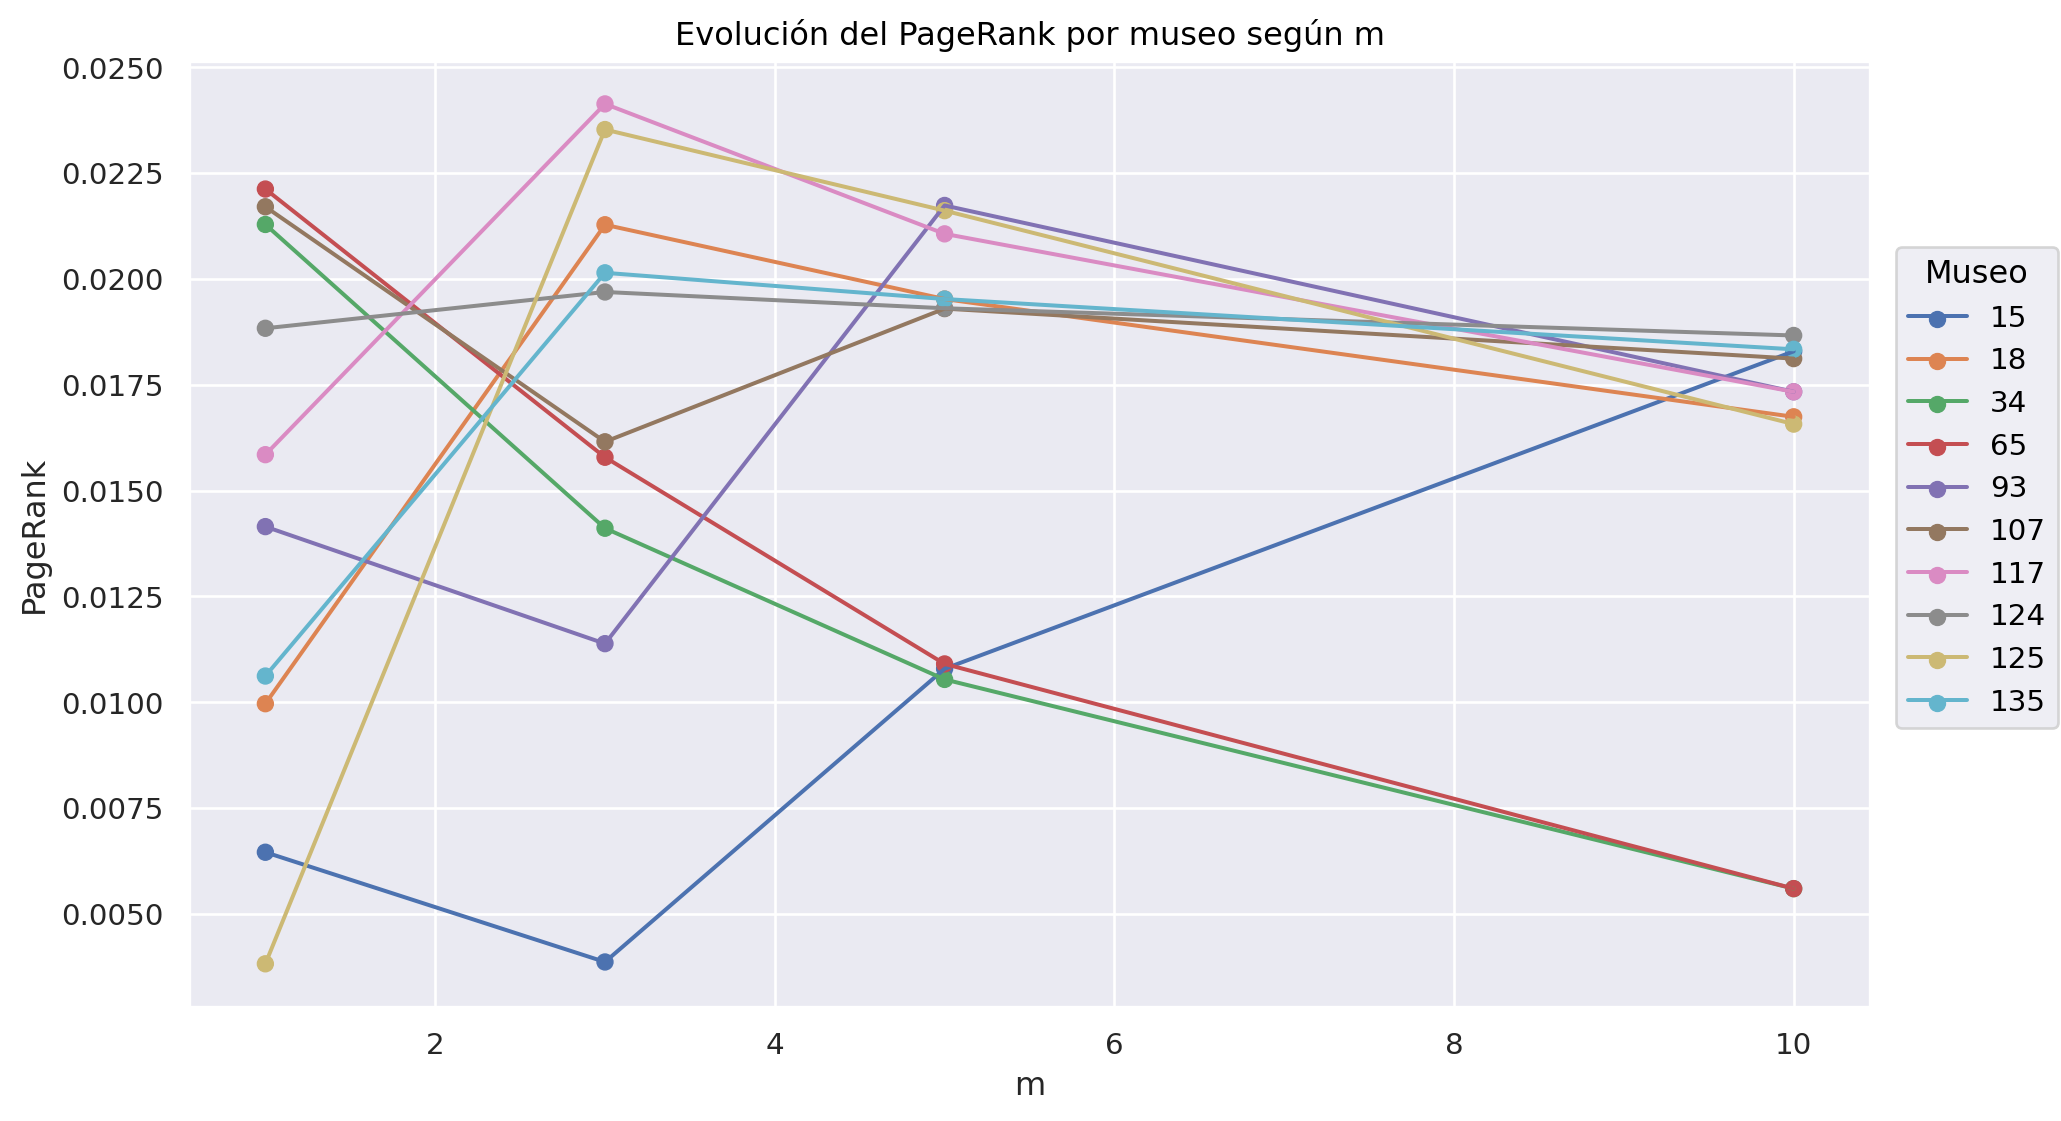

In [40]:
#Grafico pagerank en funcion de m para cada museo, agregando un punto en el valor de m
#y separando cada museo por color
(
    so.Plot(df_filtrado, x='m', y='pgr', color='museo')
    .add(so.Line())  # Linea por cada museo
    .add(so.Dot())  # Puntos marcados (opcional)
    .label(title='Evolución del PageRank por museo según m',
           x='m', y='PageRank', color='Museo')
    .scale(color=so.Nominal())  # Asegura que los colores se asignen a categorías
    .layout(size=(10, 6))  # Tamaño del gráfico
)

Del gráfico podemos ver que los valores de pagerank no son estables a medida que se aumenta m. Esto tiene sentido ya que al aumentar la cantidad de saltos por nodo la red se vuelve mas completa y hay mas distribución de cada nodo.

Visualización en el mapa de los 3 museos más centrales

Museos más centrales: 
 65     0.022124
107    0.021706
34     0.021288
dtype: float64


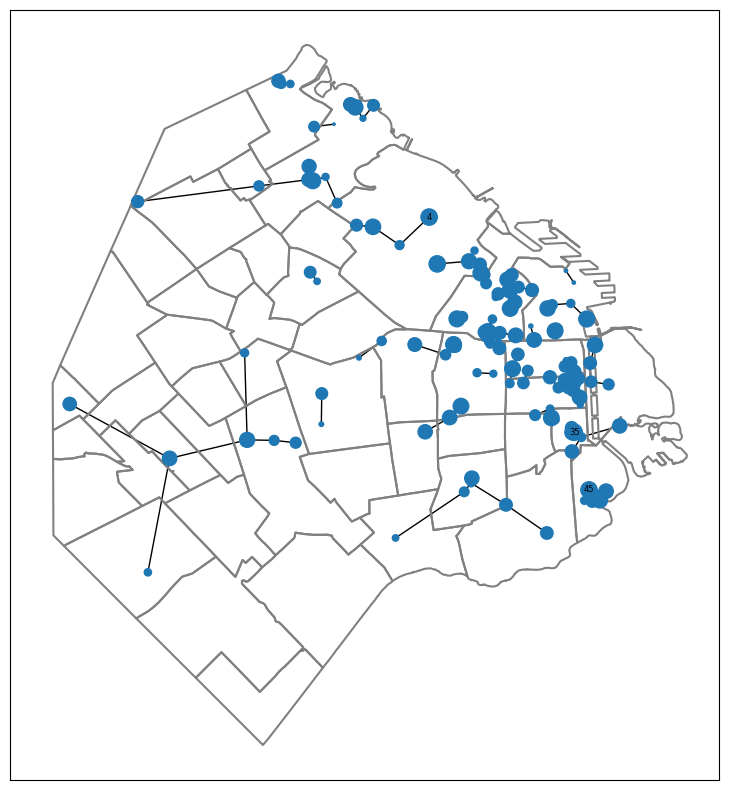

In [41]:
#Visualización de la red para m = 1.
template_funciones.prcongrafico(D, 1, 1/5)

Para m = 1 podemos ver que hay muchas zonas aisladas de la red. Los museos con pagerank más alto tienen muchos museos bien cerca.

Museos más centrales: 
 93     0.021736
125    0.021614
117    0.021066
dtype: float64


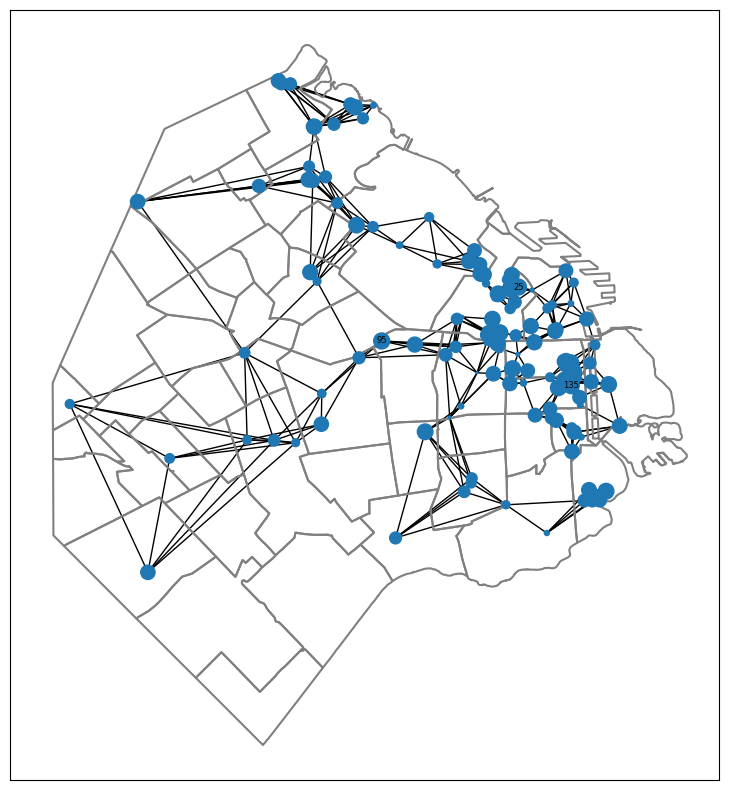

In [58]:
#Visualización de la red para m = 5.
template_funciones.prcongrafico(D, 5, 1/5)

Para m = 5 podemos ver que la relevancia se traslada por un lado a la zona del centro y a la sona sur-este de la ciudad.

Museos más centrales: 
 124    0.018665
135    0.018338
15     0.018291
dtype: float64


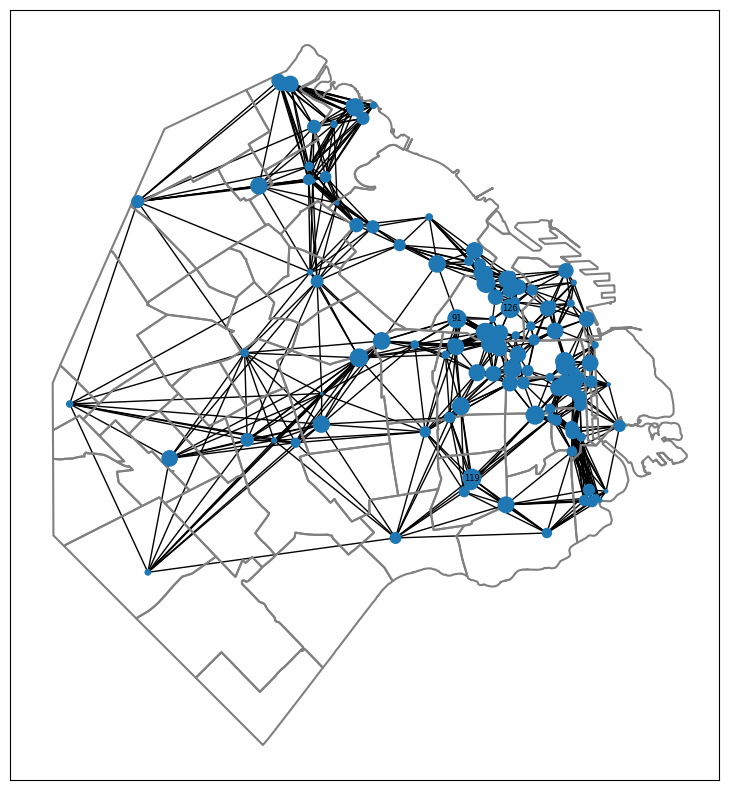

In [43]:
#Visualización de la red para m = 10.
template_funciones.prcongrafico(D, 10, 1/5)

Para m = 10 la distribucion de pagerank se vuelve mucho mas uniforme y adquiere mas relevancia el este, noreste y el centro de la red(nodo 104).

**Variación de alpha:**

Ahora vamos a realizar un gráfico similar al anterior, pero variando el valor de alpha para m=3.
Queremos verver como cambia el valor de pagerank para alpha=6/7,4/5,2/3,1/2,1/3,1/5,1/7.
También visualizaremos en el mapa como queda la red para algunos de estos valores.

In [45]:
dic = template_funciones.dicPagerankSobreAlpha(D, 3,  [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7])
df = pd.DataFrame(dic)

In [49]:
#Obtengo los 3 museos centrales para cada valor de alpha
top3_por_alpha = df.groupby('alpha').apply(lambda g: g.nlargest(3, 'pgr'))


#Devuelve un array con los museos centrales para cada m
museos_top = top3_por_alpha['museo'].unique()

#Filtro el dataframe original para quedarme con todos los valores de los museos centrales
df_filtrados = df[df['museo'].isin(museos_top)]


<ipython-input-49-4f9ae2a6de1e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_por_alpha = df.groupby('alpha').apply(lambda g: g.nlargest(3, 'pgr'))


museo     alpha       pgr
alpha                                  
0.142857 933    117  0.142857  0.028383
         941    125  0.142857  0.028281
         927    111  0.142857  0.023527
0.200000 797    117  0.200000  0.024135
         805    125  0.200000  0.023529
         698     18  0.200000  0.021281
0.333333 661    117  0.333333  0.018199
         562     18  0.333333  0.017652
         669    125  0.333333  0.017194
0.500000 426     18  0.500000  0.014128
         525    117  0.500000  0.013980
         532    124  0.500000  0.013112
0.666667 290     18  0.666667  0.011371
         389    117  0.666667  0.011202
         396    124  0.666667  0.010651
0.800000 154     18  0.800000  0.009565
         253    117  0.800000  0.009486
         224     88  0.800000  0.009312
0.857143 18      18  0.857143  0.008878
         117    117  0.857143  0.008834
         88      88  0.857143  0.008753

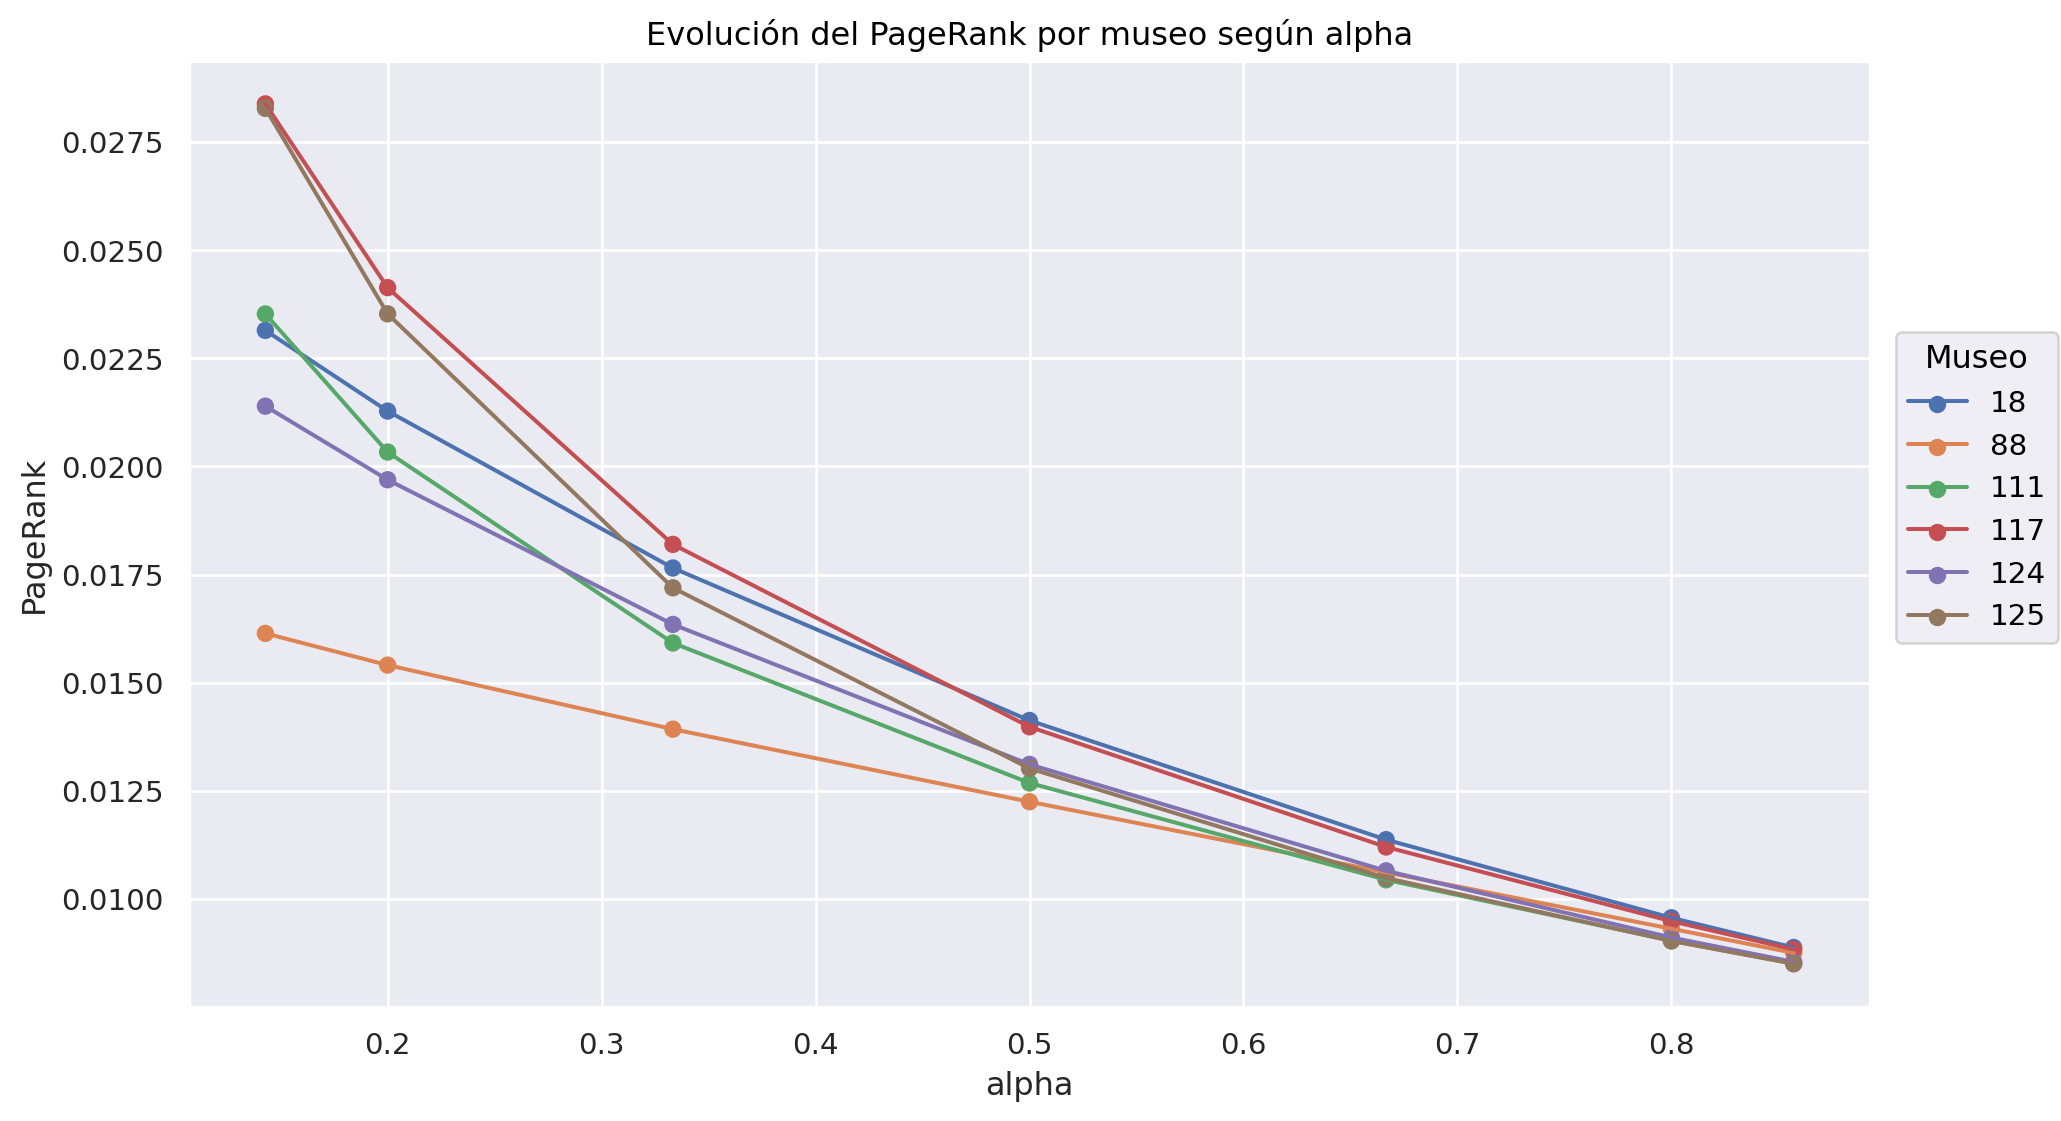

In [36]:
(
    so.Plot(df_filtrado, x='alpha', y='pgr', color='museo')
    .add(so.Line())  # Linea por cada museo
    .add(so.Dot())  # Puntos marcados (opcional)
    .label(title='Evolución del PageRank por museo según alpha',
           x='alpha', y='PageRank', color='Museo')
    .scale(color=so.Nominal())  # Asegura que los colores se asignen a categorías
    .layout(size=(10, 6))  # Tamaño del gráfico
)

Del gráfico podemos sospechar que el valor en general del pagerank de siminuye a medida que amuento alpha, pero la distribucion de los museos mas centrales es mas uniforme.

Museos más centrales: 
 117    0.028383
125    0.028281
111    0.023527
dtype: float64


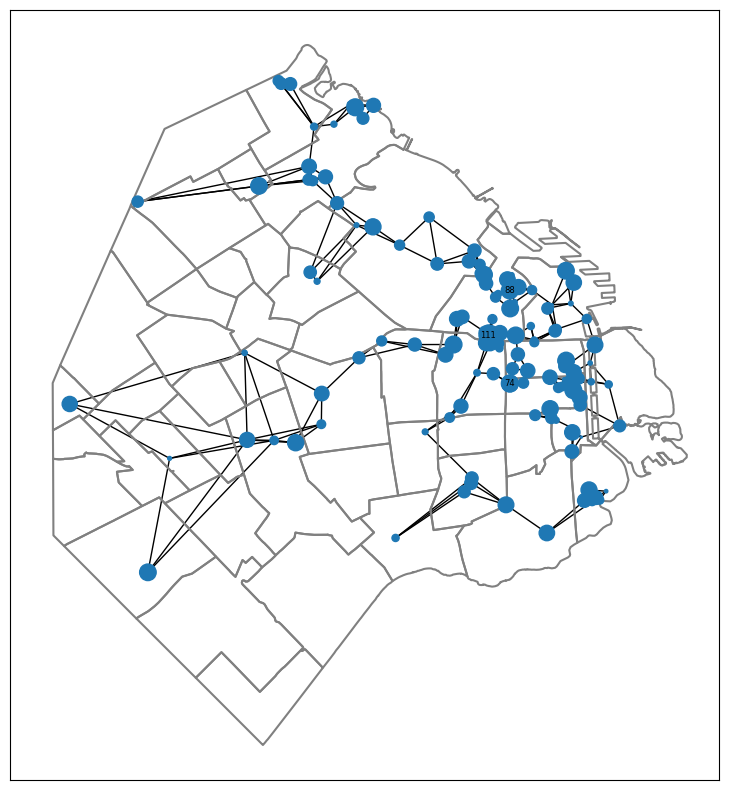

In [54]:
#Visualización de la red para alpha = 1/7
template_funciones.prcongrafico(D, 3, 1/7)

La zona mas relevante resulta la zona donde hay mas concentración de nodos.

Museos más centrales: 
 18     0.011371
117    0.011202
124    0.010651
dtype: float64


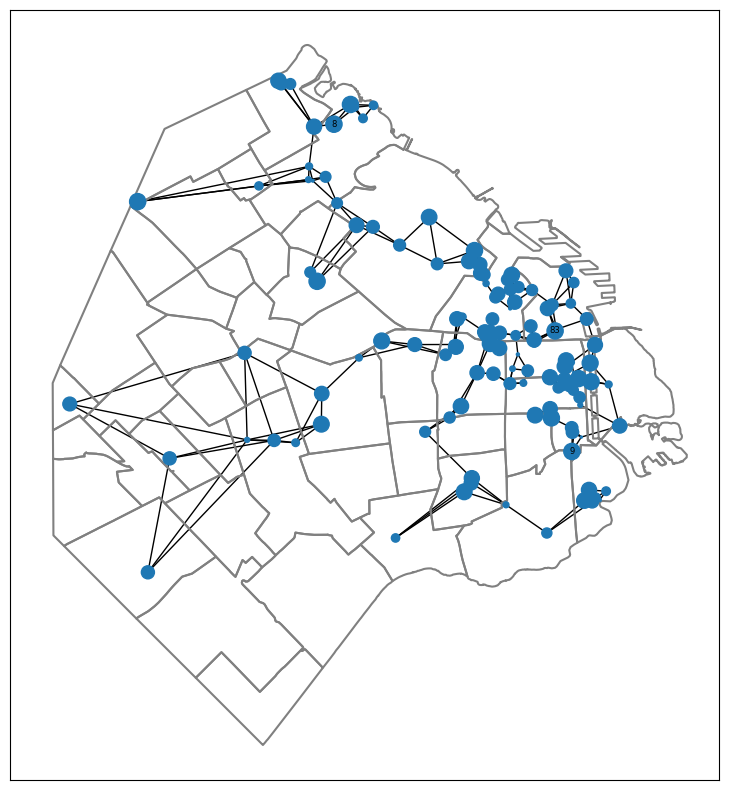

In [55]:
#Visualización de la red para alpha = 2/3
template_funciones.prcongrafico(D, 3, 2/3)

Museos más centrales: 
 18     0.008878
117    0.008834
88     0.008753
dtype: float64


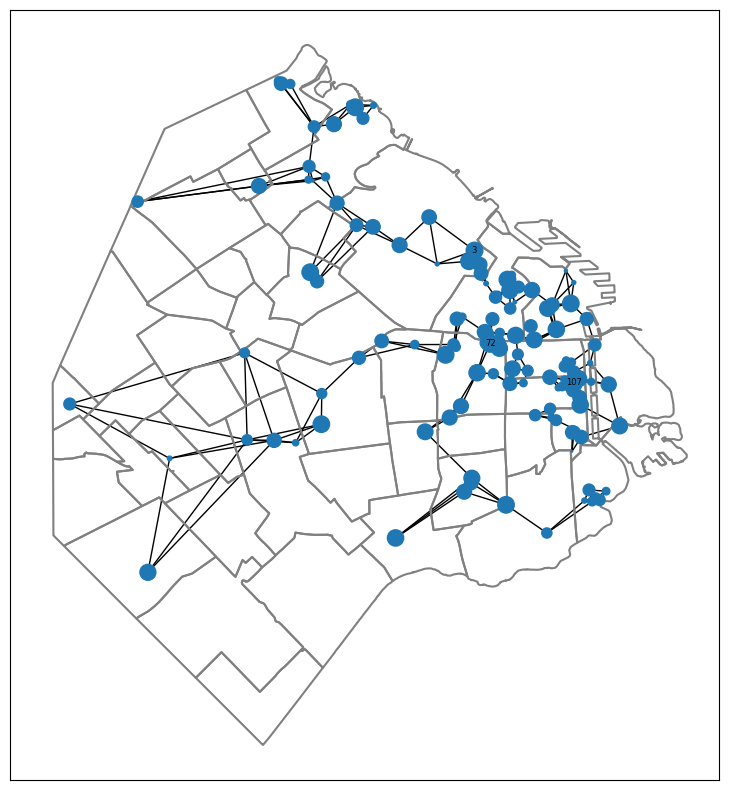

In [57]:
#Visualización de la red para alpha = 6/6
template_funciones.prcongrafico(D, 3, 6/7)

Podemos ver que a medida que aumenta alpha el valor de pagerank disminuye pero la distribución de museos centrales se mantiene relatiramente estable.

**Conclusiones:**

**Variando el valor de m para alpha = 1/5:** wl valor de pagerank resulta muy inestable. Al aumentar el valor de m obtenemos una red mucho mas conectada, donde cobra mas relevancia los nodos que se encuentran en las zonas con mas densidad de museos.

**Variando el valor de alpha para m = 3**
El valor de pagerank para cada museo tiene a ser menor a medida que alpha se acerca a 1, pero la distribución de museos más centrales resulta más uniforme.



## Punto 4:

El vector v representa la cantidad de personas que entran a la red en cada museo, y luego se mueven a travez de la red usando la matriz de transiciones C.

Osea que para r = 1(primer salto) la distribución de personas en la red es:

$$
v = C^{r-1}v = C^0v
$$

Para r = 2(segundo salto) es:

$$
C^{r-1}v = Cv
$$

Para r=3 es:

$$
C^{r-1}v = C^2v
$$

Análogamente, despues de r pasos, la distribución resulta

$$
C^{r-1}v
$$

Cada una de estas distribuciones se puede sumar y acumular las visitas totales de cada museo, representadas en el vector w, osea:

$$
w = v + Cv + C^2v + ... + C^{r-1}v
$$

Despejando v:

$$
w = (1 + C + C^2 + ... + C^{r-1})v = (\sum_{k=0}^{r-1}C^k)v
$$

Luego, como $$ B= \sum_{k=0}^{r-1}C^k $$

Tengo que
$$
w=Bv
$$

Basta ver que B es inversible para despejar v.
Lo cuál es cierto, ya que se construye a partir de elevar la matriz C, que es una matriz estocástica donde todas sus entradas son positivas, y por lo tanto su suma B también. Luego,

$$
v = B^{-1}w
$$


Como quería probar.


## Punto 5:

Quiero resolver el sistema${Bv = w}$
siendo ${B=LU}$ la factorización LU de la matriz B, es decir

$$
  LUv = w
$$


Armo la matriz B:

In [66]:
r = 3 #Cantidad de pasos de cada visitante
C_continua = template_funciones.calcula_matriz_C_continua(D)
B = template_funciones.calcula_B(C_continua, r)


/content/template_funciones.py:182: RuntimeWarning: divide by zero encountered in divide
  B = np.eye(C.shape[0]) #B inicialmente es una matriz elevado a la cero, lo que seria igual a Ccontinua elevado a la cero


Busco la descomposición L U de la matriz

In [72]:
decompLU = template_funciones.calculaLU(B)

L = decompLU[0]

U = decompLU[1]

Pienso el sistema como ${Ly = w}$ con ${Uv = y}$

Resuelvo ${Ly=w}$

In [73]:
y = scipy.linalg.solve_triangular(L, w, lower=True)

Luego resuelvo ${Uv = y}$

In [76]:
v = scipy.linalg.solve_triangular(U, y,lower=False)

Calculamos la norma 1 del vector v obtenido:

In [77]:
vtotales=np.linalg.norm(v, ord=1)
print("Visitantes Totales: ", vtotales)

Visitantes Totales:  136605.0


## Punto 6:

In [ ]:
def inversa_por_LU(A):
    #Calculamos la descomposición LU.
    L = calculaLU(A)[0]
    U = calculaLU(A)[1]

    I= np.eye(len(A)) #Matriz identidad del tamaño de A.

    A_inversa = np.zeros((len(A),len(A[0]))) #Creamos una matriz Ainversa de 0s del mismo tamaño que A.

    #Cada fila de A_inversa es igual a Aei.
    i=0
    while i < len(I):
        y = scipy.linalg.solve_triangular(L,I[i], lower=True) #Resolvemos Ly=ei.
        x = scipy.linalg.solve_triangular(U,y, lower=False) #Resolvemos Ux=y.
        A_inversa[i] = x
        i = i+1

    #Devuelve la transpuesta de A_inversa (para que Aei sea cada columna).
    return(trans(A_inversa))

In [ ]:
B_inversa = inversa_por_LU(B)

In [ ]:
def norma_1(matriz):
    return np.max(np.sum(np.abs(matriz), axis=0))

In [ ]:
def numero_condicion_norma_1(matriz, inversa):
    return norma_1(matriz) * norma_1(inversa)

In [ ]:
cond_B = numero_condicion_norma_1(B, B_inversa)

print("\nNúmero de condición de B:", cond_B)


Número de condición de B: 5.051771176665006


------------------------------------------------------
Ahora, sabiendo que:

$$
\frac{\|v - \tilde{v}\|_1}{\|v\|_1} \leq \text{cond}_1(B) \cdot \frac{\|w - \tilde{w}\|_1}{\|w\|_1}
$$

Como el número total de visitantes $ w $ tiene un error del 5\%:

$$
\frac{\|w - \tilde{w}\|_1}{\|w\|_1} = 0.05
$$

Sumado a que el número de condición de B calculado arriba es,

$$
\text{cond}_1(B) = 5.051771176665006
$$

podemos concluir que:

$$
\frac{\|v - \tilde{v}\|_1}{\|v\|_1} \leq 5.051771176665006 \cdot 0.05 = 0.2525885588332503
$$

Es decir, que el error relativo en la estimación de $ v $ (redondeado) cumple la siguiente cota:

$$
\frac{\|v - \tilde{v}\|_1}{\|v\|_1} \leq 0.25
$$

In [ ]:
error_relativo_w = 0.05  # 5%

# Cálculo de la cota del error relativo en v
cota_error_v = cond_B * error_relativo_w

print(f"Cota para el error relativo en v: {cota_error_v:.2}.")
print(f"Cota para el error relativo en v (expresada en porcentaje): {cota_error_v:.0%}.")


Cota para el error relativo en v: 0.25.
Cota para el error relativo en v (expresada en porcentaje): 25%.


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

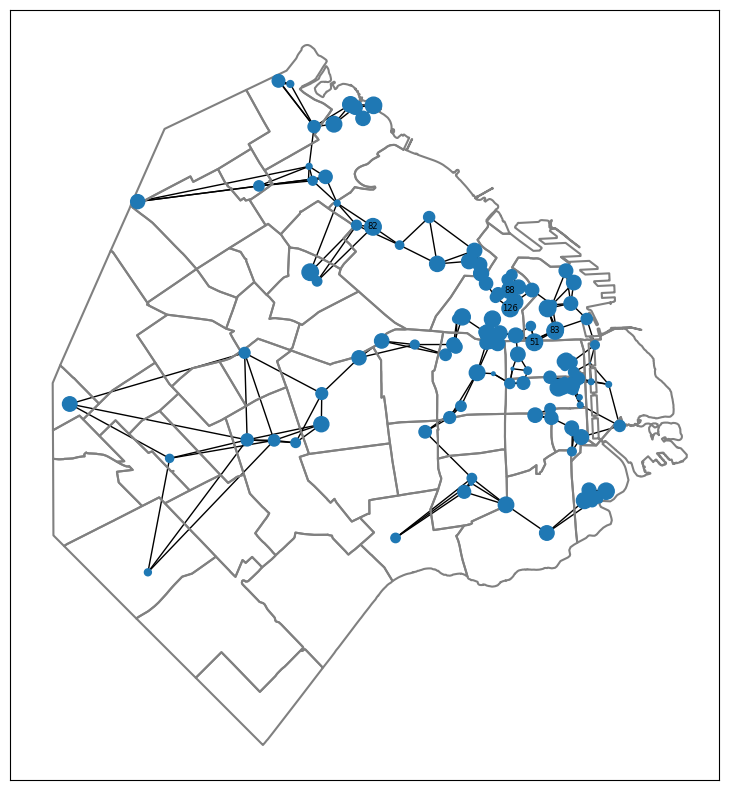

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres